In [1]:
import argparse
import copy
import gc
import math
import os
import random
import time
import h5py

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
parser = argparse.ArgumentParser()

experimentName = 'COR-GAN'

parser.add_argument("--DATASETPATH", type=str, default=os.path.expanduser('~/workspace/data/mimic-iii-processed/BINARY.h5'), help="Dataset file")

parser.add_argument("--n_epochs", type=int, default=100, help="number of epochs of training")
parser.add_argument("--n_epochs_ae", type=int, default=100, help="number of epochs of pretraining the autoencoder")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.001, help="adam: learning rate")
parser.add_argument("--weight_decay", type=float, default=0.0001, help="l2 regularization")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=32, help="number of cpu threads to use during batch generation")
parser.add_argument('--n_critic', type=int, default=5, help='number of D iters per each G iter')
parser.add_argument('--clamp', type=float, default=0.01)

parser.add_argument("--cuda", type=bool, default=True, help="CUDA activation")
parser.add_argument("--multiplegpu", type=bool, default=True, help="number of cpu threads to use during batch generation")
parser.add_argument("--num_gpu", type=int, default=1, help="Number of GPUs in case of multiple GPU")

parser.add_argument("--latent_dim", type=int, default=128, help="dimensionality of the latent space")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between samples")
parser.add_argument("--epoch_time_show", type=bool, default=True, help="interval betwen image samples")
parser.add_argument("--epoch_save_model_freq", type=int, default=100, help="number of epops per model save")
parser.add_argument("--minibatch_averaging", type=bool, default=False, help="Minibatch averaging")

parser.add_argument("--expPATH", type=str, default=os.path.expanduser('~/workspace/experiments/pytorch/model/{}'.format(experimentName)), help="Training status")

opt = parser.parse_args([])
print(opt)

Namespace(DATASETPATH='/home/mohi/workspace/data/mimic-iii-processed/BINARY.h5', b1=0.9, b2=0.999, batch_size=256, clamp=0.01, cuda=True, epoch_save_model_freq=100, epoch_time_show=True, expPATH='/home/mohi/workspace/experiments/pytorch/model/COR-GAN', latent_dim=128, lr=0.001, minibatch_averaging=False, multiplegpu=True, n_cpu=32, n_critic=5, n_epochs=100, n_epochs_ae=100, num_gpu=1, sample_interval=100, weight_decay=0.0001)


In [3]:
######################
### Initialization ###
######################

# Create experiments DIR
if not os.path.exists(opt.expPATH):
    os.system('mkdir {0}'.format(opt.expPATH))

# opt.seed = 1024 # fix seed
opt.seed = random.randint(1, 10000)

print('Random Seed: {}'.format(opt.seed))
random.seed(opt.seed)
torch.manual_seed(opt.seed)
np.random.seed(opt.seed)
cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device BUT it is not in use...")

device = torch.device("cuda:0" if opt.cuda else "cpu")
print('using \'{}\' as the tensor processor'.format(device))

Random Seed: 6460
using 'cuda:0' as the tensor processor


In [4]:
#################################
### Reading Dataset from File ###
#################################

input_data = None
with h5py.File(opt.DATASETPATH, 'r') as hf:
    input_data = hf.get('dataset')[()]

total_samples = input_data.shape[0]
feature_size = input_data.shape[1]

In [5]:
#####################
### Dataset Model ###
#####################

class EHRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.sample_size = dataset.shape[0]
        self.feature_size = dataset.shape[1]

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        return self.dataset[idx]

In [6]:
##########################
### Dataset Processing ###
##########################

train_data = input_data[:int(0.8 * total_samples)]
test_data = input_data[int(0.8 * total_samples):]
print('total samples: {}, features: {}'.format(total_samples, feature_size))
print('training data shape: {}, testing data shape: {}, dataset type: {}'.format(train_data.shape, test_data.shape, input_data.dtype))

total samples: 46520, features: 1071
training data shape: (37216, 1071), testing data shape: (9304, 1071), dataset type: float32


In [7]:
training_dataloader = DataLoader(
    EHRDataset(dataset=train_data),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu
)

testing_dataloader = DataLoader(
    EHRDataset(dataset=test_data),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu
)

In [8]:
def weightsInit(m):
    """
    Custom weight initialization.
    :param m: Input argument to extract layer type
    :return: Initialized architecture
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [9]:
########################
### AutoEncoder Loss ###
########################

class AutoEncoderLoss(nn.Module):
    def __init__(self):
        super(AutoEncoderLoss, self).__init__()

    def forward(self, input, target):
        epsilon = 1e-12
        term = target * torch.log(input + epsilon) + (1. - target) * torch.log(1. - input + epsilon)
        return torch.mean(-torch.sum(term, 1), 0)

In [17]:
#########################
### AutoEncoder Model ###
#########################

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        n_channels_base = 4

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=n_channels_base, kernel_size=5, stride=2, padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=n_channels_base, out_channels=2 * n_channels_base, kernel_size=5, stride=2, padding=0,
                      dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(2 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=2 * n_channels_base, out_channels=4 * n_channels_base, kernel_size=5, stride=3,
                      padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(4 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=4 * n_channels_base, out_channels=8 * n_channels_base, kernel_size=5, stride=3,
                      padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(8 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=8 * n_channels_base, out_channels=16 * n_channels_base, kernel_size=5, stride=3,
                      padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(16 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16 * n_channels_base, out_channels=32 * n_channels_base, kernel_size=8, stride=1,
                      padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=32 * n_channels_base, out_channels=16 * n_channels_base, kernel_size=5,
                               stride=1, padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16 * n_channels_base, out_channels=8 * n_channels_base, kernel_size=5,
                               stride=4, padding=0,
                               dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(8 * n_channels_base),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8 * n_channels_base, out_channels=4 * n_channels_base, kernel_size=7,
                               stride=4,
                               padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(4 * n_channels_base),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=4 * n_channels_base, out_channels=2 * n_channels_base, kernel_size=7,
                               stride=3,
                               padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(2 * n_channels_base),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=2 * n_channels_base, out_channels=n_channels_base, kernel_size=7, stride=2,
                               padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(n_channels_base),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=n_channels_base, out_channels=1, kernel_size=3, stride=2,
                               padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 1, x.shape[1]))
        x = self.decoder(x)
        return torch.squeeze(x)

    def decode(self, x):
        x = self.decoder(x)
        return torch.squeeze(x)

In [18]:
#############################
### Generator Model ###
#############################

# Output should be 64 * 20
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ngf = 4
        self.main = nn.Sequential(
            nn.ConvTranspose1d(opt.latent_dim, ngf * 16, 4, 1, 0),
            nn.BatchNorm1d(ngf * 16, eps=0.0001, momentum=0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(ngf * 16, ngf * 8, 4, 2, 1),
            nn.BatchNorm1d(ngf * 8, eps=0.0001, momentum=0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm1d(ngf * 4, eps=0.0001, momentum=0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm1d(ngf * 2, eps=0.0001, momentum=0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm1d(ngf, eps=0.001, momentum=0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(ngf, 1, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(-1, x.shape[1], 1)
        out = self.main(x)
        return torch.squeeze(out)

In [19]:
###########################
### Discriminator Model ###
###########################

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ndf = 16
        self.conv1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv1d(1, ndf, 8, 4, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv1d(ndf, ndf * 2, 8, 4, 1),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv1d(ndf * 2, ndf * 4, 8, 4, 1),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv1d(ndf * 4, ndf * 8, 8, 4, 1),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv5 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv1d(ndf * 8, 1, 3, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        out = self.conv1(input.view(-1, 1, input.shape[1]))
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        return torch.squeeze(out, dim=2)

In [20]:
############################
### Model Initialization ###
############################

gc.collect()
torch.cuda.empty_cache()

autoencoder = Autoencoder()
generator = Generator()
discriminator = Discriminator()

Tensor = torch.FloatTensor

one = torch.FloatTensor([1])
mone = one * -1

if opt.cuda:
    autoencoder.cuda()
    generator.cuda()
    discriminator.cuda()
    one = one.cuda()
    mone = mone.cuda()
    Tensor = torch.cuda.FloatTensor

generator_params = [{'params': generator.parameters()}, {'params': autoencoder.decoder.parameters(), 'lr': 1e-4}]

optimizer_A = torch.optim.Adam(autoencoder.parameters(), lr=opt.lr)
optimizer_G = torch.optim.Adam(generator_params, lr=opt.lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr)

generator.apply(weightsInit)
discriminator.apply(weightsInit)
autoencoder.apply(weightsInit)

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 4, kernel_size=(5,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(4, 8, kernel_size=(5,), stride=(2,))
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv1d(8, 16, kernel_size=(5,), stride=(3,))
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(16, 32, kernel_size=(5,), stride=(3,))
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv1d(32, 64, kernel_size=(5,), stride=(3,))
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
    (15): T

In [21]:
#####################################
###### AutoEncoder Training #########
#####################################

criterion = AutoEncoderLoss()

if True:
    for epoch in range(opt.n_epochs_ae):
        autoencoder.train()
        for batch in training_dataloader:
            batch = Variable(batch.type(Tensor))
            generated = autoencoder(batch)
            loss_A = criterion(generated, batch)
            optimizer_A.zero_grad()
            loss_A.backward()
            optimizer_A.step()

        errors = 0
        testing_loss = 0
        autoencoder.eval()
        for batch in testing_dataloader:
            batch = Variable(batch.type(Tensor))
            generated = autoencoder(batch)
            res = generated.round()
            diff = torch.abs(res - batch).view(1, 1, -1)[0][0].cpu().detach().numpy()
            bad_diffs = diff[diff > 0.5]
            errors += len(bad_diffs)
            testing_loss += criterion(generated, batch)

        print("[Epoch {:3d}/{:3d} of autoencoder training] [Loss: {:10.2f}] [errors: {:6d}]".format(epoch + 1, opt.n_epochs_ae, testing_loss, errors), flush=True)
    torch.save(autoencoder.state_dict(), opt.expPATH + '/autoencoder.model')

else:
    autoencoder.load_state_dict(torch.load(opt.expPATH + '/autoencoder.model'))
    autoencoder.eval()

[Epoch   1/100 of autoencoder training] [Loss:   20149.87] [errors: 399178]
[Epoch   2/100 of autoencoder training] [Loss:   12605.12] [errors: 131308]
[Epoch   3/100 of autoencoder training] [Loss:    5942.70] [errors: 131308]
[Epoch   4/100 of autoencoder training] [Loss:    6250.25] [errors: 131308]
[Epoch   5/100 of autoencoder training] [Loss:    5410.60] [errors: 131308]
[Epoch   6/100 of autoencoder training] [Loss:    3544.35] [errors: 131308]
[Epoch   7/100 of autoencoder training] [Loss:    3134.05] [errors: 131308]
[Epoch   8/100 of autoencoder training] [Loss:    2042.22] [errors: 131308]
[Epoch   9/100 of autoencoder training] [Loss:    2206.41] [errors: 131308]
[Epoch  10/100 of autoencoder training] [Loss:    1409.50] [errors: 131308]
[Epoch  11/100 of autoencoder training] [Loss:    1306.06] [errors: 131308]
[Epoch  12/100 of autoencoder training] [Loss:    1361.67] [errors: 131308]
[Epoch  13/100 of autoencoder training] [Loss:    1242.81] [errors: 131308]
[Epoch  14/1

In [22]:
errors = 0
for batch in testing_dataloader:
    batch = Variable(batch.type(Tensor))
    generated = autoencoder(batch)
    res = generated.round()
    diff = torch.abs(res - batch).view(1, 1, -1)[0][0].cpu().detach().numpy()
    bad_diffs = diff[diff > 0.5]
    errors += len(bad_diffs)
print("total number of bad digits: {}".format(errors))

total number of bad digits: 39295


In [23]:
if True:
    batches_done = 0

    discriminator.train()
    generator.train()

    gen_iterations = 0
    for epoch in range(opt.n_epochs):
        epoch_start = time.time()

        for batch in training_dataloader:
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch = Variable(batch.type(Tensor))

            for dp in discriminator.parameters():
                dp.requires_grad = True

            if gen_iterations < 25 or gen_iterations % 500 == 0:
                n_critic = 100
            else:
                n_critic = opt.n_critic

            for _ in range(opt.n_critic):
                for dp in discriminator.parameters():
                    dp.data.clamp_(-opt.clamp, opt.clamp)

                # reset gradients of discriminator
                optimizer_D.zero_grad()

                loss_D_real = torch.mean(discriminator(batch), dim=0)
                loss_D_real.backward(one)

                # Sample noise as generator input
                z = torch.randn(batch.shape[0], opt.latent_dim, device=device)
                # Generate a batch of images
                fake_batch = torch.squeeze(autoencoder.decode(generator(z).unsqueeze(dim=2)))

                # Error
                loss_D_fake = torch.mean(discriminator(fake_batch.detach()), dim=0)
                loss_D_fake.backward(mone)

                # Optimizer stepz
                optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------

            for dp in discriminator.parameters():
                dp.requires_grad = False

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = torch.randn(batch.shape[0], opt.latent_dim, device=device)

            # Generate a batch of images
            fake_batch = torch.squeeze(autoencoder.decode(generator(z).unsqueeze(dim=2)))

            # uncomment if there is no autoencoder
            loss_G = torch.mean(discriminator(fake_batch), dim=0)
            loss_G.backward(one)
            optimizer_G.step()
            batches_done += 1

            if batches_done % 100 == 0:
                print('[Epoch {:3d}/{:3d}] [Batch {:3d}/{:3d}] [D loss: {:.5f}] [G loss: {:.5f}]'.format(epoch + 1, opt.n_epochs, batches_done % len(training_dataloader), len(training_dataloader), loss_D_real.item() + loss_D_fake.item(), loss_G.item()))

        print('[Epoch {:3d}/{:3d}] [Time: {:.2f}] [D loss: {:.5f}] [G loss: {:.5f}]'.format(epoch + 1, opt.n_epochs, time.time() - epoch_start, loss_D_real.item() + loss_D_fake.item(), loss_G.item()))

    torch.save(generator.state_dict(), opt.expPATH + '/generator.model')
    torch.save(discriminator.state_dict(), opt.expPATH + '/discriminator.model')
else:
    generator.load_state_dict(torch.load(opt.expPATH + '/generator.model'))
    discriminator.load_state_dict(torch.load(opt.expPATH + '/discriminator.model'))

[Epoch   1/100] [Batch 100/146] [D loss: 1.00216] [G loss: 0.50894]
[Epoch   1/100] [Time: 7.51] [D loss: 1.00261] [G loss: 0.50863]
[Epoch   2/100] [Batch  54/146] [D loss: 1.00243] [G loss: 0.50720]
[Epoch   2/100] [Time: 8.04] [D loss: 1.00267] [G loss: 0.50553]
[Epoch   3/100] [Batch   8/146] [D loss: 1.00262] [G loss: 0.50614]
[Epoch   3/100] [Batch 108/146] [D loss: 1.00317] [G loss: 0.50635]
[Epoch   3/100] [Time: 7.89] [D loss: 1.00235] [G loss: 0.50555]
[Epoch   4/100] [Batch  62/146] [D loss: 1.00203] [G loss: 0.50484]
[Epoch   4/100] [Time: 7.72] [D loss: 1.00181] [G loss: 0.50414]
[Epoch   5/100] [Batch  16/146] [D loss: 1.00214] [G loss: 0.50483]
[Epoch   5/100] [Batch 116/146] [D loss: 1.00269] [G loss: 0.50555]
[Epoch   5/100] [Time: 8.05] [D loss: 1.00268] [G loss: 0.50442]
[Epoch   6/100] [Batch  70/146] [D loss: 1.00344] [G loss: 0.50437]
[Epoch   6/100] [Time: 7.05] [D loss: 1.00372] [G loss: 0.50441]
[Epoch   7/100] [Batch  24/146] [D loss: 1.00312] [G loss: 0.50473

In [24]:
autoencoder.eval()
generator.eval()
discriminator.eval()

Discriminator(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(8,), stride=(4,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(4,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv1d(128, 1, kernel_size=(3,), stride=(1,))
    (1): Sigmoid()
  )
)

In [25]:
num_fake_batches = 80
fake_data = torch.zeros((0, feature_size), device='cpu')
for _ in range(num_fake_batches):
  z = torch.randn(opt.batch_size, 128, device=device)
  generated_batch = generator(z)
  fake_batch = torch.squeeze(autoencoder.decode(generator(z).unsqueeze(dim=2)))
  fake_data = torch.cat((fake_data, fake_batch.round().to('cpu')), 0)

In [26]:
np.save(os.path.join(opt.expPATH, "synthetic.npy"), fake_data.detach().cpu().numpy(), allow_pickle=False)

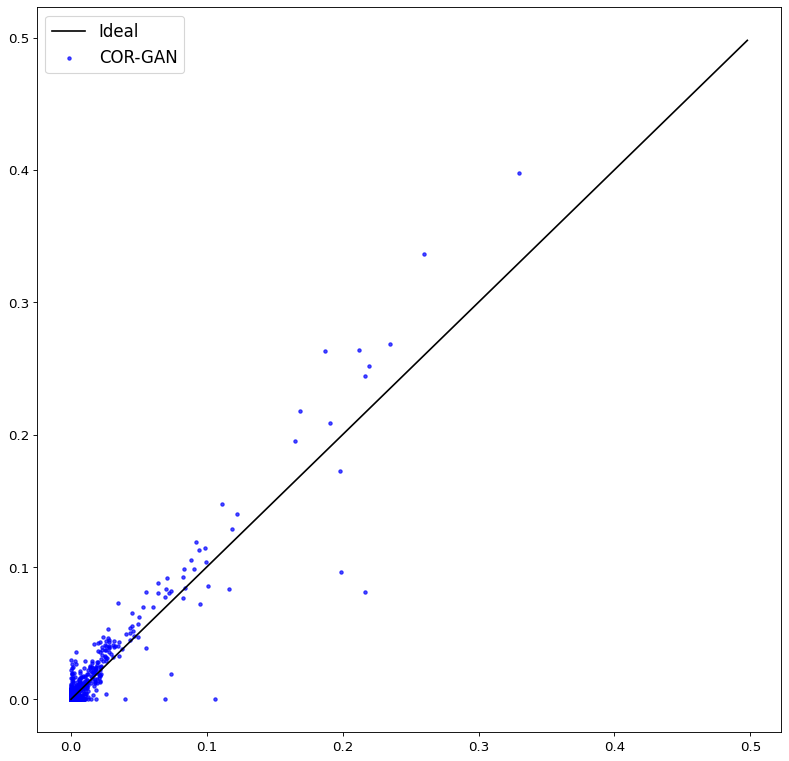

In [28]:
gen_samples = fake_data.detach().cpu().numpy()
# gen_samples = np.load(os.path.join(opt.expPATH, "synthetic.npy"), allow_pickle=False)

# Load real data
real_samples = train_data[0:gen_samples.shape[0], :]

# Dimenstion wise probability
prob_real = np.mean(real_samples, axis=0)
prob_syn = np.mean(gen_samples, axis=0)

from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.scatter(prob_real, prob_syn, c="b", alpha=0.7, label="COR-GAN", s=9)
x_max = max(np.max(prob_real), np.max(prob_syn))
x = np.linspace(0, x_max + 0.1, 1000)
p2 = plt.plot(x, x, linestyle='-', color='k', label="Ideal")  # solid
plt.tick_params(labelsize=12)
plt.legend(loc=2, prop={'size': 15})
# plt.title('Scatter plot p')
# plt.xlabel('x')
# plt.ylabel('y')
plt.show()
